In [1]:
import pickle
import copy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from experiments import *
from utils import *

In [2]:
splits = ['iid','noniid']

benchs = ['lb', 'mmlu', 'helm', 'alpaca','mmlu_fields']
titles = {'lb':'Open LLM Leaderboard','mmlu':'MMLU','helm':'HELM','alpaca':'AlpacaEval'}

agg = 'leaderboard' # 'leaderboard', 'scenarios'
results = 'acc' # 'acc', 'rank'
agg_metric = 'avg' #'std' (std=variation across seeds)

if results == 'acc': ylim = (0,.1)
elif results == 'rank': 
    if agg_metric == 'std':
        ylim = (0,.1)
    else:
        ylim = (.5,1)
else: raise NotImplementedError

In [3]:
methods = ['random_naive', 'anchor_naive', 'anchor-irt_naive', #'anchor-irt_gpirt']
           #'random_pirt', 'anchor_pirt', 'anchor-irt_pirt']#,
           #'random_cirt','anchor_cirt', 'anchor-irt_cirt']#,
           'random_gpirt', 'anchor_gpirt', 'anchor-irt_gpirt']

In [4]:
table_avg = {}
table_std = {}
model_perf = {}
for bench in benchs:
    table_avg[bench] = {}
    table_std[bench] = {}
    model_perf[bench] = {}
        
    for split in splits:
        table_avg[bench][split] = {}
        table_std[bench][split] = {}
        model_perf[bench][split] = {}
        

        with open(f'results/accs_{bench}_split-{split}_iterations-5.pickle', 'rb') as handle:
            data = pickle.load(handle)

        models = list(data.keys())
        number_items = list(data[models[0]].keys())
        scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
        data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])
        scores = load_scores(bench, split)
        
        if agg == 'leaderboard':
            if bench=='helm': 
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = winrate(scores, axis=1).mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = winrate(data, axis=2).mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(winrate(data, axis=2).mean(axis=3)-winrate(scores, axis=1).mean(axis=0)[None,None,:,None])
                elif results == 'rank': 
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(winrate(data, axis=2).mean(axis=3).shape)
                                rank_corrs[i,j,l] = stats.spearmanr(winrate(data, axis=2).mean(axis=3)[i,j,:,l], winrate(scores.T, axis=0).mean(axis=1)).statistic
                    data=rank_corrs

                else: 
                    raise NotImplementedError
            else: 
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = scores.mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = data.mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(data.mean(axis=3)-scores.mean(axis=0)[None,None,:,None])
                elif results == 'rank': 
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(data.mean(axis=3).shape)
                                rank_corrs[i,j,l] = stats.spearmanr(data.mean(axis=3)[i,j,:,l], scores.T.mean(axis=1)).statistic
                    data=rank_corrs
                else: 
                    raise NotImplementedError
        elif agg == 'scenarios':
            if results == 'acc': 
                data = np.abs(data-scores.T[None,None,:,:,None]).mean(axis=3)
            elif results == 'rank': 
                rank_corrs = np.zeros(data.mean(axis=2).shape)
                for i in range(rank_corrs.shape[0]):
                    for j in range(rank_corrs.shape[1]):
                        for k in range(rank_corrs.shape[2]):
                            for l in range(rank_corrs.shape[3]):
                                rank_corrs[i,j,k,l] = stats.spearmanr(data[i,j,:,k,l], scores.T[:,k]).statistic
                data=rank_corrs
            else: 
                raise NotImplementedError
        else:
            raise NotImplementedError
            
        if agg_metric=='avg':
            data = data.mean(-1) #iterations
        elif agg_metric=='std':
            data = data.std(-1)
        else:
            raise NotImplementedError
            
        
        for i,method in enumerate(methods):
            table_avg[bench][split][method] = {}
            table_std[bench][split][method] = {}

            for j,number_item in enumerate(number_items):
                if agg == 'leaderboard' and results == 'rank':
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = data[i,j]
                    table_std[bench][split][method][number_item] = 0
                else: 
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = np.mean(data, axis=-1)[i,j]
                    table_std[bench][split][method][number_item] = data.std(-1)[i,j]

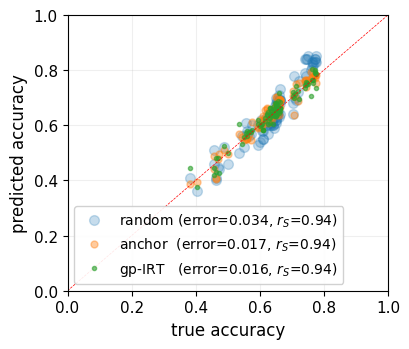

In [5]:
if results == 'acc':
    if agg == 'leaderboard':
        split = 'noniid'
        iteration = 0
        number_item = 100

        alphas = {'random_naive':.25,'anchor_naive':.4,'anchor-irt_naive':.4,'anchor-irt_gpirt':.6}
        markersize = {'random_naive':7,'anchor_naive':5,'anchor-irt_naive':5,'anchor-irt_gpirt':3}
        names = {'random_naive':'random','anchor-irt_naive':'anchor-IRT ','anchor_naive':'anchor ','anchor-irt_gpirt':'gp-IRT  '}
        plt.figure(figsize=(1.2*3.5,1.2*3))

        for i,bench in enumerate(['mmlu']): #benchs[:4]
            axis = {'lb':'avg. score', 'mmlu':'accuracy', 'helm':'mean win rate', 'alpaca':'win rate'}
            for method in ['random_naive','anchor_naive','anchor-irt_gpirt']: #

                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method])

            plt.legend(fontsize=10, framealpha=.9)
            #plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=12)
            plt.ylabel('predicted '+axis[bench], size=12)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 11  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/mmlu_leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

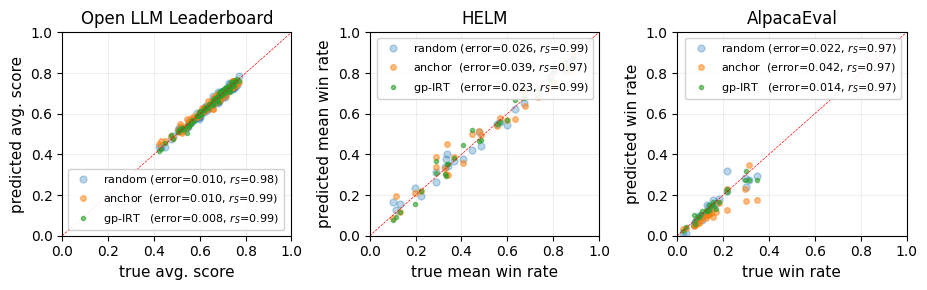

In [6]:
if results == 'acc':
    if agg == 'leaderboard':
        split = 'noniid'
        iteration = 0
        number_item = 100

        alphas = {'random_naive':.3,'anchor_naive':.5,'anchor-irt_naive':.5,'anchor-irt_gpirt':.6}
        markersize = {'random_naive':5,'anchor_naive':4,'anchor-irt_naive':4,'anchor-irt_gpirt':3}
        names = {'random_naive':'random','anchor-irt_naive':'anchor-IRT ','anchor_naive':'anchor ','anchor-irt_gpirt':'gp-IRT  '}
        plt.figure(figsize=(12.5*3/4,3))

        for i,bench in enumerate(['lb','helm','alpaca']): #benchs[:4]
            plt.subplot(1, 3, i+1)
            axis = {'lb':'avg. score', 'mmlu':'score', 'helm':'mean win rate', 'alpaca':'win rate'}
            for method in ['random_naive','anchor_naive','anchor-irt_gpirt']: #

                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method])

            plt.legend(fontsize=8, framealpha=.9)
            plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=11)
            plt.ylabel('predicted '+axis[bench], size=11)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 10  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

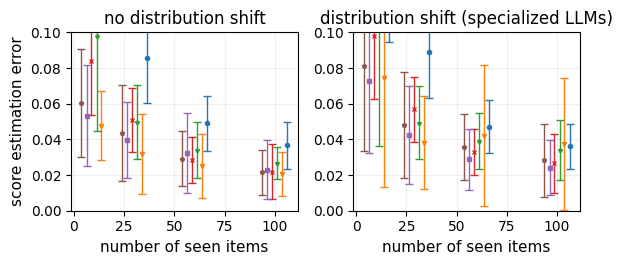

In [7]:
plt.figure(figsize=(6,2.75))
bench='mmlu_fields'
# Iterate over your benchmarks
for i, split in enumerate(splits):  # Replace `benchmarks` with your list of benchmarks
    # Plot on the ith subplot
    plt.subplot(1, 2, i+1)
    if results == 'rank': ylabel='Spearman correlation \nfor LLMs ranking'
    else: ylabel='score estimation error'
        
    plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                    title={'iid':'no distribution shift', 'noniid':'distribution shift (specialized LLMs)'}[split],
                    xlabel='number of seen items',
                    ylabel=ylabel, ylim=ylim, legend=False, error_bar=True, show_ylabel=split=='iid')
    plt.tight_layout()
plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

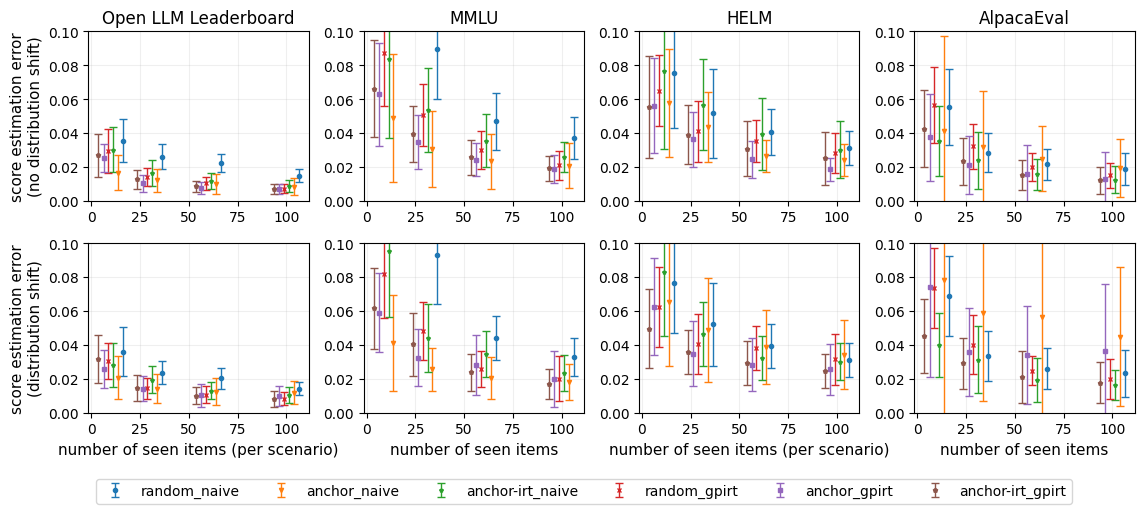

In [8]:
if agg == 'leaderboard':
    plt.figure(figsize=(.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)
    
    for j, split in enumerate(splits):
        ylabel_dic = {'iid':'(no distribution shift)', 'noniid':'(distribution shift)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'score estimation error\n{ylabel_dic[split]}'
  
        # Iterate over your benchmarks
        for i, bench in enumerate(benchs[:4]):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of seen items'
            else: xlabel='number of seen items (per scenario)'    
            # Plot on the ith subplot
            plt.subplot(2, 4, 4*j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),
                            error_bar=True,show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/leaderboard_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

In [9]:
if agg == 'scenarios':
    plt.figure(figsize=(.5*.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)
    
    for j, split in enumerate(splits):
        # Create a figure and a set of subplots
        

        ylabel_dic = {'iid':'(no distribution shift)', 'noniid':'(distribution shift)'}
        
        if results == 'rank': ylabel=f'avg. scenarios Spearman\n  corr. for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'average scenarios score\n estimation error\n{ylabel_dic[split]}'

        # Iterate over your benchmarks
        for i, bench in enumerate(['lb','helm']):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of items'
            else: xlabel='number of items (per scenario)'    
            # Plot on the ith subplot
            plt.subplot(2, 2, 2*j +i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),error_bar=True,
                            show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/avg_scenarios_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

## Lambda plot

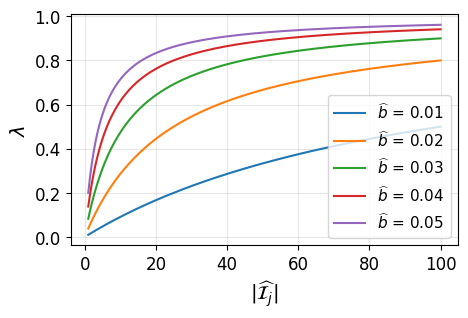

In [10]:
def get_lambda(n, b, sigma2):
    return (b**2) / (sigma2/n + b**2)

# Constants
sigma2 = .01  # fixed sigma2
b_values = np.arange(0.01, 0.051, 0.01)  # b values from 0.01 to 0.05
n_values = np.linspace(1, 100, 200)  # n values from 1 to 100

# Plotting
plt.figure(figsize=(5, 3))
for b in b_values:
    lambda_values = [get_lambda(n, b, sigma2) for n in n_values]
    plt.plot(n_values, lambda_values, label='$\\widehat{b}$'+' = {:.2f}'.format(b))

tick_label_size = 12  # Example size, adjust as needed
plt.tick_params(axis='x', labelsize=tick_label_size)
plt.tick_params(axis='y', labelsize=tick_label_size)
plt.xlabel('$|\widehat{\mathcal{I}_j}|$', size=14)
plt.ylabel('$\lambda$', size=14)
plt.legend(fontsize=11)
plt.grid(alpha=.3)
plt.savefig(f'plots/lambda.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()


## MMLU study

In [11]:
def ess(w):
    assert abs(w.sum()-1)<1e-4
    return 1/(w.shape[0]*np.sum((w)**2))

In [10]:
with open('results/samples_mmlu_iterations-5.pickle', 'rb') as handle:
    sample_data = pickle.load(handle)

In [11]:
number_item = 100
methods = ['random', 'anchor', 'anchor-irt']
iterations = list(sample_data['item_weights']['anchor-irt'][number_item].keys())

In [12]:
sample_data['item_weights']['anchor-irt'].keys()

dict_keys([10, 30, 60, 100])

In [13]:
with open(f'results/results_mmlu_split-iid_iterations-5.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
opt_iterations={}
for method in methods:
    opt_iterations[method] = np.argmin(np.mean([results[model][number_item][method+'_naive']['mmlu'] for model in results.keys()],axis=0))

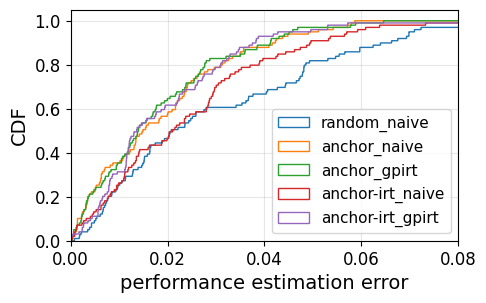

In [16]:
plt.figure(figsize=(5, 3))

bins = np.linspace(0, .1, 9999)  # 50 bins from 0 to max_value


for method in methods:
    y1 = [results[model][number_item][method+'_naive']['mmlu'][opt_iterations[method]] for model in results.keys()]
    plt.hist(y1, alpha=1, bins=bins, cumulative=True, histtype='step', density =True, label=method+'_naive', linewidth=1)
    if method=='random':
        pass
    else:
        y2 = [results[model][number_item][method+'_gpirt']['mmlu'][opt_iterations[method]] for model in results.keys()]
        #print(method,np.mean(y1),np.mean(y2))
        plt.hist(y2, alpha=1, bins=bins, cumulative=True, histtype='step', density =True, label=method+'_gpirt', linewidth=1)

tick_label_size = 12  # Example size, adjust as needed
plt.tick_params(axis='x', labelsize=tick_label_size)
plt.tick_params(axis='y', labelsize=tick_label_size)
plt.xlabel('performance estimation error', size=14)
plt.ylabel('CDF', size=14)
plt.legend(fontsize=11)
plt.grid(alpha=.3)
plt.xlim(0,.08)
plt.savefig(f'plots/performance_mini_mmlu.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()
plt.show()

anchor 0.018549860295665088 0.017838044723754293
anchor-irt 0.024082251076550435 0.01911282157232199


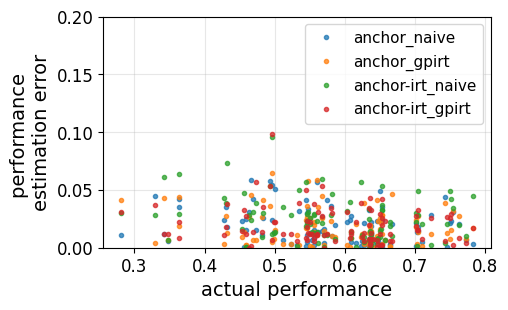

In [17]:
plt.figure(figsize=(5, 3))

methods = ['anchor', 'anchor-irt']
scores = load_scores(bench='mmlu', split='iid').squeeze()

for method in methods:
    y1 = [results[model][number_item][method+'_naive']['mmlu'][opt_iterations[method]] for model in results.keys()]
    y2 = [results[model][number_item][method+'_gpirt']['mmlu'][opt_iterations[method]] for model in results.keys()]
    print(method,np.mean(y1),np.mean(y2))
    plt.plot(scores.squeeze(), y1, 'o', markersize=3, label=method+'_naive', alpha=.75)
    plt.plot(scores.squeeze(), y2, 'o', markersize=3,  label=method+'_gpirt', alpha=.75)

tick_label_size = 12  # Example size, adjust as needed
plt.tick_params(axis='x', labelsize=tick_label_size)
plt.tick_params(axis='y', labelsize=tick_label_size)
plt.xlabel('actual performance', size=14)
plt.ylabel('performance \nestimation error', size=14)
plt.ylim(0,.2)
plt.legend(fontsize=11)
plt.grid(alpha=.3)
plt.savefig(f'plots/performance2_mini_mmlu.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

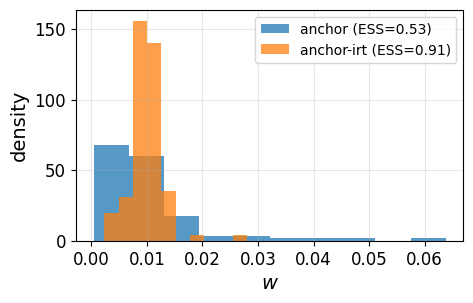

In [18]:
plt.figure(figsize=(5, 3))

tick_label_size = 12  # Example size, adjust as needed
plt.tick_params(axis='x', labelsize=tick_label_size)
plt.tick_params(axis='y', labelsize=tick_label_size)

for method in methods:
    w = sample_data['item_weights'][method][number_item][opt_iterations[method]]['mmlu']
    plt.hist(w, bins=10, alpha=.75, density =True, label=method+f' (ESS={ess(w):.2f})')
    plt.grid(alpha=.3)
    plt.ylabel('density', size=14)
    plt.xlabel('$w$', size=14)
    plt.legend()
plt.savefig(f'plots/w_mini_mmlu.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

In [19]:
with open('data/lb.pickle', 'rb') as handle:
    data = pickle.load(handle) 
#scenarios
scenarios = lb_scenarios
scenarios = {'mmlu':scenarios['mmlu']}
chosen_scenarios = ['mmlu']
# Prepare data and scenarios
scenarios_position, subscenarios_position = prepare_data(chosen_scenarios, scenarios, data)
#scores = create_responses(chosen_scenarios, scenarios, data)


In [20]:
points_per_sub = {'subscenario':[s[22:-2] for s in scenarios['mmlu']]}
for method in methods:
    seen_data = sample_data['seen_items'][method][number_item][opt_iterations[method]]
    w = sample_data['item_weights'][method][number_item][opt_iterations[method]]['mmlu']
    points_per_sub[method] = [np.sum([w[i] for i,s in enumerate(seen_data) if s in subscenarios_position['mmlu'][sub]]) for sub in scenarios['mmlu']]

In [21]:
df = pd.DataFrame(points_per_sub)

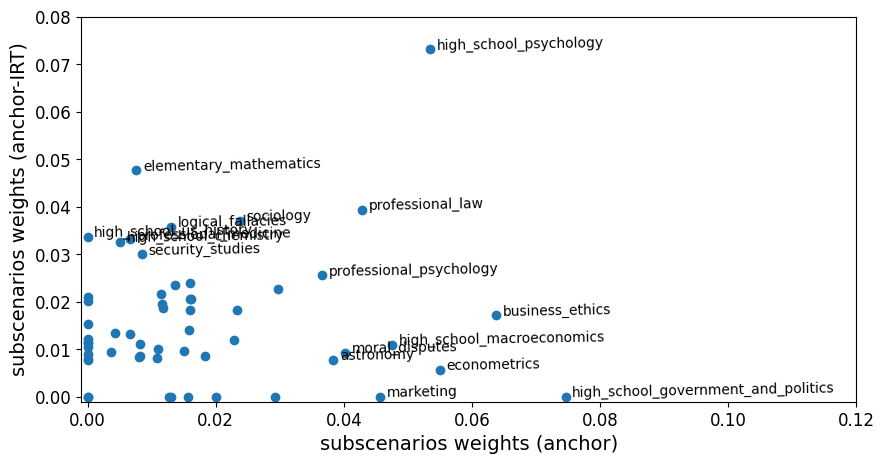

In [22]:
plt.figure(figsize=((2)*5, 5))

# Creating a scatter plot
plt.scatter(points_per_sub['anchor'], points_per_sub['anchor-irt'])

# Labeling points where at least one of the coordinates is greater than 0.03
for i, label in enumerate(points_per_sub['subscenario']):
    if points_per_sub['anchor'][i] > 0.03 or points_per_sub['anchor-irt'][i] > 0.03:
        plt.annotate(label, (points_per_sub['anchor'][i] + .001, points_per_sub['anchor-irt'][i]), size=10, rotation=1)


tick_label_size = 12  # Example size, adjust as needed
plt.tick_params(axis='x', labelsize=tick_label_size)
plt.tick_params(axis='y', labelsize=tick_label_size)
plt.ylim(-0.001,.08)
plt.xlim(-0.001,.12)
plt.xlabel('subscenarios weights (anchor)', size=14)
plt.ylabel('subscenarios weights (anchor-IRT)', size=14)
plt.savefig(f'plots/w_sub_mini_mmlu.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

## Running time (ability inference)

Verify this later.

In [17]:
import pandas as pd

In [105]:
df = pd.read_csv('results/estimate_ability_parameters_timing.txt', header=None)
df = df[0].str.split(' ',expand=True).iloc[:,:3].rename(columns={0: "D", 1: "I", 2:"s"})
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df = df.loc[df.D==5]
df = df.loc[df.I<=2000]
df = np.array(df.groupby(['I'])['s'].mean().reset_index())

In [106]:
df

array([[6.00000000e+00, 1.91329479e-02],
       [7.00000000e+00, 2.72758484e-02],
       [8.00000000e+00, 3.58811855e-02],
       ...,
       [1.49800000e+03, 5.70569754e-02],
       [1.49900000e+03, 5.96564683e-02],
       [1.50000000e+03, 5.48387229e-02]])

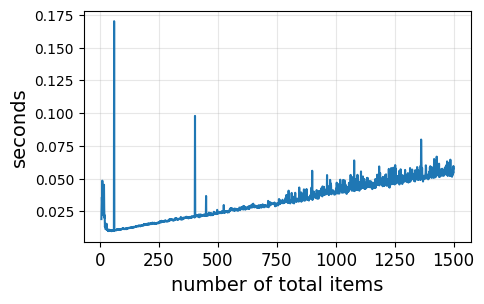

In [107]:
plt.figure(figsize=(5, 3))

tick_label_size = 12  # Example size, adjust as needed
plt.tick_params(axis='x', labelsize=tick_label_size)
plt.plot(df[:,0],df[:,1])
plt.grid(alpha=.3)
plt.ylabel('seconds', size=14)
plt.xlabel('number of total items', size=14)
plt.savefig(f'plots/running_item_inference.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()